### Introduction and setting expectations

This notebook illustrates some of the basic properties of NestedTensor such as dim, size and nested_size and how it relates to padding and masking.

We're currently most interested in collecting feedback on the API design and general usability of this project as per the [prototype classification](https://pytorch.org/blog/pytorch-feature-classification-changes/#prototype) of this feature. This also means that, for now, you're not likely to see a wall-clock performance improvement.

### Setup
First we download the binaries. Currently the nestedtensor project ships with its own version of torch and torchvision, since it's built on top of a fork of PyTorch. We recommend you install these binaries in a new environment to keep them separate from your usual PyTorch installation.

You can find the links to wheels for Python 3.6, 3.7 and 3.8 [on our README](https://github.com/pytorch/nestedtensor#binaries). There are not yet any CUDA binaries, but they'll follow shortly. We do frequent manual releases, so if you're running into any issues check if there's a newer version available. Here we're copying the links for Python 3.6, which is the version colab uses.



In [1]:
%%capture
!pip install https://download.pytorch.org/nestedtensor/whl/nightly/cpu/py3.6/torch-1.8.0_nestedtensor_0.1.1_cpu-cp36-cp36m-linux_x86_64.whl;
!pip install https://download.pytorch.org/nestedtensor/whl/nightly/cpu/py3.6/nestedtensor-0.1.1_cpu-cp36-cp36m-linux_x86_64.whl;
!pip install https://download.pytorch.org/nestedtensor/whl/nightly/cpu/py3.6/torchvision-0.1.1_cpu-cp36-cp36m-linux_x86_64.whl;

Next we import the necessary packages. nestedtensor is a separate package, but upon import registers itself with torch via its [dispatch registration mechanism](https://pytorch.org/tutorials/advanced/dispatcher.html), which ensures seamless compatability between NestedTensors and torch Tensors. Let's also download some images for our presentation here.

In [2]:
%%capture
import torch
import nestedtensor
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
!wget "https://raw.githubusercontent.com/pytorch/nestedtensor/master/tutorials/assets/000000006040.jpg"
!wget "https://raw.githubusercontent.com/pytorch/nestedtensor/master/tutorials/assets/000000017714.jpg"
!wget "https://raw.githubusercontent.com/pytorch/nestedtensor/master/tutorials/assets/000000026926.jpg"
!wget "https://raw.githubusercontent.com/pytorch/nestedtensor/master/tutorials/assets/000000028285.jpg"
EXAMPLE_IMAGE_NAMES = ["000000006040.jpg", "000000017714.jpg", "000000026926.jpg", "000000028285.jpg"]
EXAMPLE_IMAGE_TENSORS = [torchvision.transforms.functional.to_tensor(Image.open(img).convert('RGB')) for img in EXAMPLE_IMAGE_NAMES]

For this tutorial we handselected four beautiful images from the 2017 Validation dataset of the [CODO dataset](https://cocodataset.org/#download).

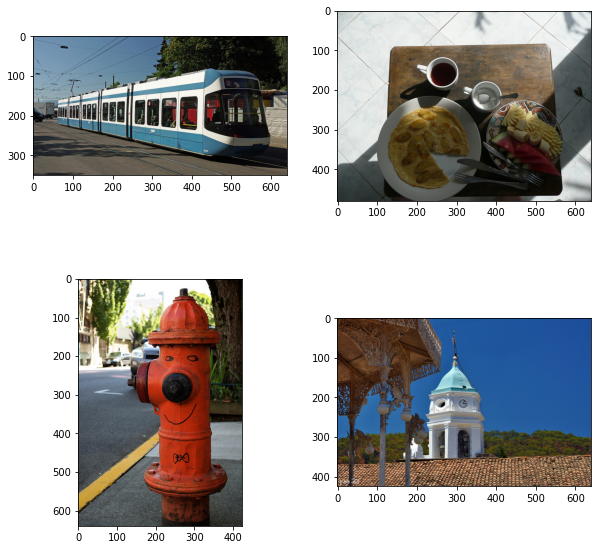

In [3]:
def display_image_tensors(tensors):
    fig = plt.figure(figsize=(10, 10))
    for i, img in enumerate(tensors):
        fig.add_subplot(2, 2, i + 1)
        plt.imshow(img.permute(1, 2, 0).numpy())
    plt.show()
display_image_tensors(EXAMPLE_IMAGE_TENSORS)

### Concurrently applying conv2d to images of different sizes

Now let's say, for some reason, we want to apply a 2d convolution to each of these images, but they are all of varying sizes. Of course torch's conv2d functional does not accept a list of Tensors, but instead a regular torch tensor of shape N x C x H x W. Let's apply conv2d to the first image to remind ourselves of how this works. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


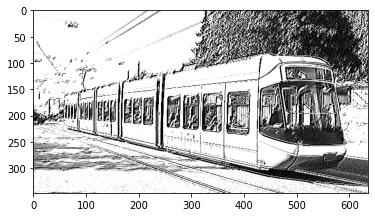

In [4]:
torch.manual_seed(1010)
weight = torch.randn(5, 5).repeat(3, 3, 1, 1)
result = torch.conv2d(EXAMPLE_IMAGE_TENSORS[0].unsqueeze(0), weight).squeeze(0).permute(1, 2, 0)
plt.imshow(result.numpy())

Now, let's say we want to apply conv2d to all images at once. This commonly is assumed to happen for performance reasons where most notably GPUs benefit from being allowed to process a lot of data at once. Many PyTorch users know this as "batching" and many do this by hand. Let's step through what this might look like. 

A common approach is to create a single Tensor that contains the data of the four images by padding the images such that they're all of the same size and then maintaining an annotation alongside it that determines whether a data entry is simply used for padding or not.

In [5]:
max_h = max(t.size(1) for t in EXAMPLE_IMAGE_TENSORS)
max_w = max(t.size(2) for t in EXAMPLE_IMAGE_TENSORS) 
data_tensor = torch.zeros(len(EXAMPLE_IMAGE_TENSORS), 3, max_h, max_w)
mask_tensor = torch.zeros_like(data_tensor)
for i, t in enumerate(EXAMPLE_IMAGE_TENSORS):
    data_tensor[i, :, :t.size(1), :t.size(2)].copy_(t)
    mask_tensor[i, :, :t.size(1), :t.size(2)].fill_(1)

Let's look at what these padded images and their masks look like.

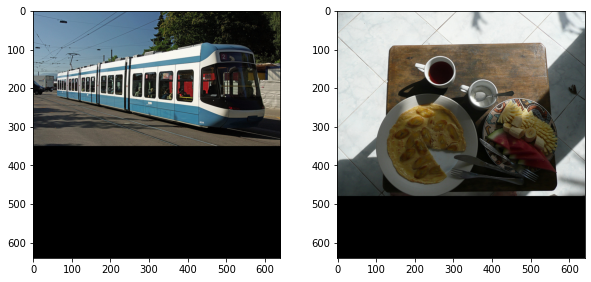

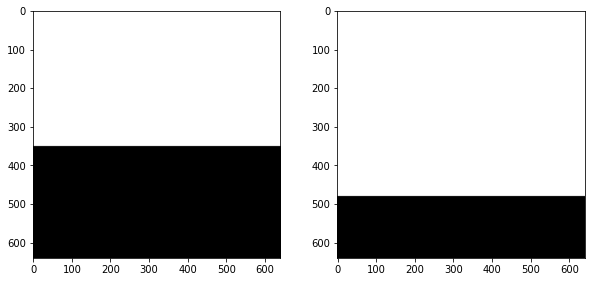

In [6]:
display_image_tensors(data_tensor.unbind()[:2])
display_image_tensors(mask_tensor.unbind()[:2])

It's important to note here that we don't actually need to worry what values we are using for padding here, because convolutions are applied locally. We just need to calculate the size of the output region and can then crop and retrieve our result and we don't even need to involve our masks.

This is not the case for other operations such as max, min, sum, matmul or var, where the operation is applied to the entire Tensor at once. We'll get to that later.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


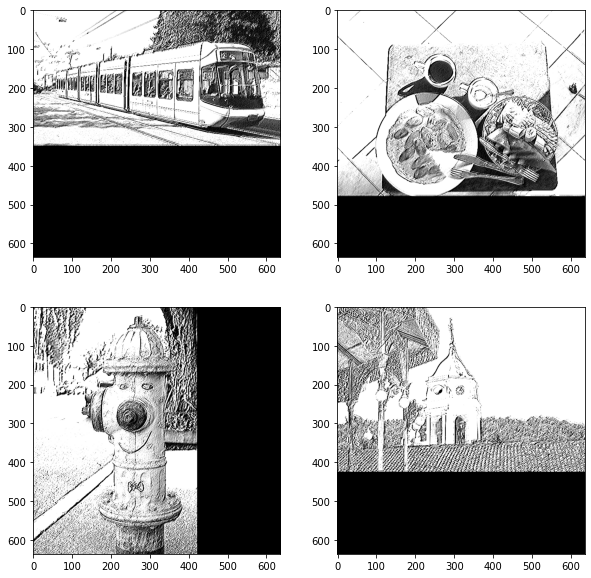

In [7]:
padded_result = torch.conv2d(data_tensor, weight)
display_image_tensors(padded_result.unbind())

Now let's cut out the output regions and test that they are actually the result we want



In [8]:
results = []
for orig, result in zip(EXAMPLE_IMAGE_TENSORS, padded_result.unbind()):
  # The output region is 4 pixels smaller than the input because we're applying a 5 by 5 convolution
  results.append(result[:, :orig.size(1) - 4, :orig.size(2) - 4])
  # To test the result we're going to apply conv2d again here but one image at a time
  print(torch.eq(torch.conv2d(orig.unsqueeze(0), weight), results[-1]).all().item())

True
True
True
True


Here is what this same operation looks like using NestedTensor

In [9]:
nt = nestedtensor.nested_tensor(EXAMPLE_IMAGE_TENSORS)
results_nt = torch.conv2d(nt, weight)
for r, r_nt in zip(results, results_nt):
    print(torch.eq(r, r_nt).all().item())

True
True
True
True


### NestedTensor and padding and masking
You can also construct the nestedtensor from the padded version of the data. This is useful when you want to gradually apply NestedTensor in the context of a pipeline where you already are using padding and masking. More on this later.

In [10]:
nt_from_padded = nestedtensor.nested_tensor_from_tensor_mask(data_tensor, mask_tensor)
print(torch.eq(nt, nt_from_padded).all())

tensor(True)


nestedtensor ships with construction and conversion to tensors with masks and tensors with speical non-data identifying values for NestedTensor.

In [11]:
tensor = torch.tensor(
        [[[0.8413, 0.7325, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.6334, 0.5473, 0.3273, 0.0564],
         [0.3023, 0.6826, 0.3519, 0.1804],
         [0.8431, 0.1645, 0.1821, 0.9185]]])
mask = torch.tensor(
        [[[ True,  True, False, False],
         [False, False, False, False],
         [False, False, False, False]],

        [[ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True]]])
nt2 = nestedtensor.nested_tensor_from_tensor_mask(tensor, mask)
print(nestedtensor.nested_tensor_from_tensor_mask(tensor, mask))
print(nestedtensor.nested_tensor_from_padded_tensor(tensor, padding=0))

nested_tensor([
  tensor([[0.8413, 0.7325]]),
  tensor([[0.6334, 0.5473, 0.3273, 0.0564],
          [0.3023, 0.6826, 0.3519, 0.1804],
          [0.8431, 0.1645, 0.1821, 0.9185]])
])
nested_tensor([
  tensor([[0.8413, 0.7325]]),
  tensor([[0.6334, 0.5473, 0.3273, 0.0564],
          [0.3023, 0.6826, 0.3519, 0.1804],
          [0.8431, 0.1645, 0.1821, 0.9185]])
])


In [12]:
print(nt2.to_tensor_mask())
print(nt2.to_padded_tensor(padding=-10))

(tensor([[[0.8413, 0.7325, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.6334, 0.5473, 0.3273, 0.0564],
         [0.3023, 0.6826, 0.3519, 0.1804],
         [0.8431, 0.1645, 0.1821, 0.9185]]]), tensor([[[ True,  True, False, False],
         [False, False, False, False],
         [False, False, False, False]],

        [[ True,  True,  True,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True]]]))
tensor([[[  0.8413,   0.7325, -10.0000, -10.0000],
         [-10.0000, -10.0000, -10.0000, -10.0000],
         [-10.0000, -10.0000, -10.0000, -10.0000]],

        [[  0.6334,   0.5473,   0.3273,   0.0564],
         [  0.3023,   0.6826,   0.3519,   0.1804],
         [  0.8431,   0.1645,   0.1821,   0.9185]]])


### NestedTensor and resnet18

Let's take a second and look at what a NestedTensor looks like.

For now it simply prints as a nested list of Tensors.

In [13]:
print(nt)

nested_tensor([
  tensor([[[0.4431, 0.4431, 0.4353,  ..., 0.1451, 0.0784, 0.0627],
           [0.4471, 0.4431, 0.4392,  ..., 0.1137, 0.0784, 0.0627],
           [0.4510, 0.4471, 0.4392,  ..., 0.1137, 0.0118, 0.1255],
           ...,
           [0.1765, 0.1608, 0.1765,  ..., 0.3294, 0.3725, 0.3686],
           [0.2078, 0.2039, 0.2314,  ..., 0.4275, 0.3333, 0.3412],
           [0.2118, 0.2235, 0.2471,  ..., 0.4000, 0.4392, 0.4353]],
  
          [[0.5647, 0.5647, 0.5647,  ..., 0.1490, 0.0824, 0.0667],
           [0.5686, 0.5647, 0.5686,  ..., 0.1176, 0.0824, 0.0745],
           [0.5725, 0.5686, 0.5686,  ..., 0.1216, 0.0196, 0.1451],
           ...,
           [0.1843, 0.1647, 0.1765,  ..., 0.2745, 0.3176, 0.3059],
           [0.2118, 0.2078, 0.2353,  ..., 0.3882, 0.2941, 0.3098],
           [0.2196, 0.2314, 0.2549,  ..., 0.3451, 0.3882, 0.3961]],
  
          [[0.6863, 0.6863, 0.6863,  ..., 0.1294, 0.0510, 0.0353],
           [0.6902, 0.6863, 0.6902,  ..., 0.0863, 0.0588, 0.0471],
      

We can unbind a NestedTensor (which is already a regular, but lesser known torch Tensor operation with the same behavior) to get an actual Python list and take a closer look at some of the constiuents.

In [14]:
print(nt.unbind()[0])

tensor([[[0.4431, 0.4431, 0.4353,  ..., 0.1451, 0.0784, 0.0627],
         [0.4471, 0.4431, 0.4392,  ..., 0.1137, 0.0784, 0.0627],
         [0.4510, 0.4471, 0.4392,  ..., 0.1137, 0.0118, 0.1255],
         ...,
         [0.1765, 0.1608, 0.1765,  ..., 0.3294, 0.3725, 0.3686],
         [0.2078, 0.2039, 0.2314,  ..., 0.4275, 0.3333, 0.3412],
         [0.2118, 0.2235, 0.2471,  ..., 0.4000, 0.4392, 0.4353]],

        [[0.5647, 0.5647, 0.5647,  ..., 0.1490, 0.0824, 0.0667],
         [0.5686, 0.5647, 0.5686,  ..., 0.1176, 0.0824, 0.0745],
         [0.5725, 0.5686, 0.5686,  ..., 0.1216, 0.0196, 0.1451],
         ...,
         [0.1843, 0.1647, 0.1765,  ..., 0.2745, 0.3176, 0.3059],
         [0.2118, 0.2078, 0.2353,  ..., 0.3882, 0.2941, 0.3098],
         [0.2196, 0.2314, 0.2549,  ..., 0.3451, 0.3882, 0.3961]],

        [[0.6863, 0.6863, 0.6863,  ..., 0.1294, 0.0510, 0.0353],
         [0.6902, 0.6863, 0.6902,  ..., 0.0863, 0.0588, 0.0471],
         [0.6941, 0.6902, 0.6902,  ..., 0.0706, 0.0000, 0.

or simply use indexing

In [15]:
print(nt[0])

tensor([[[0.4431, 0.4431, 0.4353,  ..., 0.1451, 0.0784, 0.0627],
         [0.4471, 0.4431, 0.4392,  ..., 0.1137, 0.0784, 0.0627],
         [0.4510, 0.4471, 0.4392,  ..., 0.1137, 0.0118, 0.1255],
         ...,
         [0.1765, 0.1608, 0.1765,  ..., 0.3294, 0.3725, 0.3686],
         [0.2078, 0.2039, 0.2314,  ..., 0.4275, 0.3333, 0.3412],
         [0.2118, 0.2235, 0.2471,  ..., 0.4000, 0.4392, 0.4353]],

        [[0.5647, 0.5647, 0.5647,  ..., 0.1490, 0.0824, 0.0667],
         [0.5686, 0.5647, 0.5686,  ..., 0.1176, 0.0824, 0.0745],
         [0.5725, 0.5686, 0.5686,  ..., 0.1216, 0.0196, 0.1451],
         ...,
         [0.1843, 0.1647, 0.1765,  ..., 0.2745, 0.3176, 0.3059],
         [0.2118, 0.2078, 0.2353,  ..., 0.3882, 0.2941, 0.3098],
         [0.2196, 0.2314, 0.2549,  ..., 0.3451, 0.3882, 0.3961]],

        [[0.6863, 0.6863, 0.6863,  ..., 0.1294, 0.0510, 0.0353],
         [0.6902, 0.6863, 0.6902,  ..., 0.0863, 0.0588, 0.0471],
         [0.6941, 0.6902, 0.6902,  ..., 0.0706, 0.0000, 0.

Since NestedTensors are strictly more general in their shape than torch Tensors we introduce new methods called nested_size (and nested stride) to get a representation for their shape. 

NestedTensor's still carry sizes, but they may be undefined (None) along some of the dimensions. See the optional section on more details if you want a strict definition for when it is None, but roughly speaking the size is None, if the constiuents along that dimension are not of the size. In the example below the constiuents carry 351, 480, 640 and 425 and their size along their second dimension, which means the size along the third dimension of the NestedTensor is None.


In [16]:
print(nt.nested_size())
print(nt.size())

NestedSize([
	torch.Size([3, 351, 640]),
	torch.Size([3, 480, 640]),
	torch.Size([3, 640, 423]),
	torch.Size([3, 425, 640])
])
(4, 3, None, None)


A NestedTensor is very similar to a regular torch Tensor, with the only key difference that its shape can be more complex. That means most importantly that a NestedTensor size (and stride) can be irregular and for some dimensions may not be defined (hence None). Instead NestedTensors come with a nested_size and a nested_stride.

Everything else still applies. It still only has a single dimension, single dtype, single layout, single device. It is backed by a single, contiguous region of memory.

In [17]:
print(nt.dim())
print(nt.layout)
print(nt.device)
print(nt.dtype)
print(nt.numel())

4
torch.strided
cpu
torch.float32
3223680


A NestedTensor is semantically interchangeable with a regular Tensor if its nested_size is regular and regular torch operators will behave just as expected. It is only when a NestedTensor's shape becomes irregular, that an operator might behave differently.

In [18]:
nt_tensor = nestedtensor.nested_tensor(8 * [torch.randn(3, 100, 100)])
print(nt_tensor.nested_size())
print(nt_tensor.size())

NestedSize([
	torch.Size([3, 100, 100]),
	torch.Size([3, 100, 100]),
	torch.Size([3, 100, 100]),
	torch.Size([3, 100, 100]),
	torch.Size([3, 100, 100]),
	torch.Size([3, 100, 100]),
	torch.Size([3, 100, 100]),
	torch.Size([3, 100, 100])
])
(8, 3, 100, 100)


We could have alternatively attempted to generalize torch.Tensor by introducing a nested_size method and nested_tensor constructor to produce irregular torch.Tensors, but introducing a separate construct (namely NestedTensor) is presumably easier at first.



To showcase just how similar NestedTensors are to regular Tensors let us feed one into a torchvision resnet18.

In [19]:
model = torchvision.models.resnet.resnet18(pretrained=True).eval()
result_model_nt = model(nestedtensor.nested_tensor(EXAMPLE_IMAGE_TENSORS)).unbind()
# The outputs won't match bit-perfect, but they are allclose
for i, img in enumerate(EXAMPLE_IMAGE_TENSORS):
   a = result_model_nt[i]
   b = model(img.unsqueeze(0)).squeeze(0)
   # atol and rtol from PyTorch test settings found here https://github.com/pytorch/pytorch/blob/2fe382e931ec5a31715c247fea2b292f7d72cb66/torch/testing/_internal/common_utils.py#L921
   print(torch.allclose(a, b, atol=1e-5, rtol=1.3e-6))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



True
True
True
True


### [Optional] More details of NestedTensor properties
Let's spend a bit more time going into the details of NestedTensor properties

Every non-empty NestedTensor is of at least dimension one, because it must represent at least a list. For each level lists with list entries added we increase the nested dimension by one. That means this NestedTensor is of nested dimension 1.

The tensor dimension is three, because the Tensor constiuents are of dimension three.

The overall dimension is four because it is the sum of the nested and tensor dimension.


In [20]:
nt = nestedtensor.nested_tensor(EXAMPLE_IMAGE_TENSORS)
print(nt.nested_dim())
print(nt.tensor_dim())
print(nt.dim())

1
3
4


Here is another quick example, but this time with nested dimension two.

In [21]:
a = torch.tensor([[1]])
b = torch.tensor([[2, 2],
                  [3, 3],
                  [4, 4],
                  [5, 5]])
nt2 = nestedtensor.nested_tensor([[a], [b]])

print(nt2.nested_dim())
print(nt2.tensor_dim())
print(nt2.dim())

2
2
4


NestedTensor.nested_size can be thought of as the result of replacing the regular Tensor constiuents by their size.

NestedTensor.nested_size optionally also accepts a dim argument. This will return a slice across the given dimension. This might be easier to explain via an example below.

nt2.nested_size(0) returns the length of nt or the number of entries in the list it represents. This is very similar to ```list.__len__```.

nt2.nested_size(1) returns the length of the entries of the outer list.

nt2.nested_size(2) returns the first entry of each Tensor constiuent's size. 

nt2.nested_size(3) returns the second entry of each Tensor constiuent's size.


In [22]:
print(nt2)
print(nt2.nested_size())
print(len(nt2))
print(nt2.nested_size(0))
print(nt2.nested_size(1))
print(nt2.nested_size(2))
print(nt2.nested_size(3))

nested_tensor([
  [
    tensor([[1.]])
  ],
  [
    tensor([[2., 2.],
            [3., 3.],
            [4., 4.],
            [5., 5.]])
  ]
])
NestedSize([
	NestedSize([
		torch.Size([1, 1])
	]),
	NestedSize([
		torch.Size([4, 2])
	])
])
2
2
(1, 1)
((1,), (4,))
((1,), (2,))


**NestedTensor.size** is a function that returns a tuple of the format
(n_1, n_2, ..., n_nested_dim, t_1, t_2, ..., t_tensor_dim). The sizes lead by n_ are defined 
to be the nested sizes each at a nested dimension, the sizes lead by t_ are defined to be the 
tensor sizes each at a tensor dimension. They are a reduced version of nested_size and 
aim to represent the size across a slice of nested_size.

size(i) is of value k if all numerical entries of nested_size(dim) are of value k, otherwise it is None.
size() is a tuple with entries size(i)
In this case most size(i) will be None, except for the first. We will later see examples of NestedTensors where this is not the case

In [23]:
print(nt2.size())

(2, 1, None, None)


### Summary
This was a bit of a whirlwind tour to show the basics of the value behind the nestedtensor project and illustrate some of the basic NestedTensor behavior and properties. You can find more tutorials on the [overview page](https://github.com/pytorch/nestedtensor/tree/master/tutorials).